In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import train
import network_unet as unet
import network_hed as hed
import torch

#reimport
import evaluation as eval
import importlib
importlib.reload(eval)

import utils
importlib.reload(utils)

<module 'utils' from '/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/utils.py'>

In [2]:
# Points dictionary
points_dict = np.load('../data/SIVE/points_dict.npy', allow_pickle=True).item()
points_dict.keys()

dict_keys(['20240623T114351_tramore', '20221211T114501_rossnowlagh', '20221204T115451_rossnowlagh', '20221116T114349_rossnowlagh', '20221007T114349_rossnowlagh', '20220922T114401_rossnowlagh', '20220910T115359_rossnowlagh', '20220905T115411_rossnowlagh', '20220813T114401_rossnowlagh', '20220811T115409_rossnowlagh', '20220722T115409_rossnowlagh', '20220607T115411_rossnowlagh', '20220604T114401_rossnowlagh', '20220523T115359_rossnowlagh', '20220408T115401_rossnowlagh', '20220326T114351_rossnowlagh', '20220319T115401_rossnowlagh', '20240211T113311_portrane', '20220323T113321_portrane', '20201002T114401_portrane', '20190707T113321_portrane', '20190207T113321_portmarnock', '20171129T113419_portmarnock', '20230904T113321_bull_island', '20230604T114349_bull_island', '20230530T114351_bull_island', '20230420T114351_bull_island', '20190920T113319_bull_island', '20190826T113321_bull_island', '20190707T113321_bull_island', '20190627T113321_bull_island', '20190501T114351_bull_island', '20190411T114

In [8]:
def get_all_results(model_paths, test_paths,points_dict):
    results = []

    for i,model_path in enumerate(model_paths):
        model_name = os.path.basename(model_path)
        print(f"Processing model {i+1}/{len(model_paths)}: {model_name}")

        model, meta_data = utils.get_model(model_path)
        
        targets = []
        preds = []

        for path in test_paths:
            image,  pred_full = eval.get_combined_pred(model,meta_data,points_dict, path, batch_size=1)

            targets.append(image[-1])
            preds.append(pred_full)

        test_metrics, test_arr = eval.eval_metrics(targets, preds)

        row = meta_data | test_metrics
        results.append(row)
        
    return results

def plot_all_predictions(model, meta_data, test_paths, batch_size=1,crop_remove=200):

    for path in test_paths:
        image,  pred_full = eval.get_combined_pred(model,meta_data,points_dict, path, batch_size=1,post_process=False)
        image = image[:,crop_remove:-crop_remove, crop_remove:-crop_remove]
        pred_full = pred_full[crop_remove:-crop_remove, crop_remove:-crop_remove]

        pred_thinned = utils.thin_edge_map(pred_full)

        ID = os.path.basename(path).split('.')[0]
        points = points_dict[ID][1]

        fig, ax = plt.subplots(1, 4, figsize=(12, 6))
        rgb_image = utils.get_rgb(image, contrast=0.3)
        ax[0].imshow(rgb_image)
        ax[0].set_title("RGB Image")
        
        ax[1].imshow(1-image[-1], cmap='gray')
        ax[1].set_title("Target")

        ax[2].imshow(1-pred_full, cmap='gray')
        ax[2].set_title("Prediction")

        ax[3].imshow(1-pred_thinned, cmap='gray')
        ax[3].set_title("Thinned Prediction")

        for a in ax:
            a.set_xticks([])
            a.set_yticks([])
        
        plt.show()

In [4]:
# Test data
target_pos = -1

test_file = '../data/SIVE/test_1/'
test_paths = glob.glob(test_file + '*.npy')
test_targets = [np.load(file)[target_pos] for file in test_paths]
test_input = [np.load(file)[0:target_pos] for file in test_paths]

print("Test dimensions:")
print(np.shape(test_targets[0]))
print(np.shape(test_input[0]))

Test dimensions:
(750, 650)
(5, 750, 650)


Model metadata:
name: SIVE_04JUN2025_HED_BigEarthNet_trainable_guided_wBCE.pth
date: 04JUN2025
arcitecture: HED
backbone: BigEarthNet
freeze_backbone: trainable
guidance: True
loss_function: wBCE


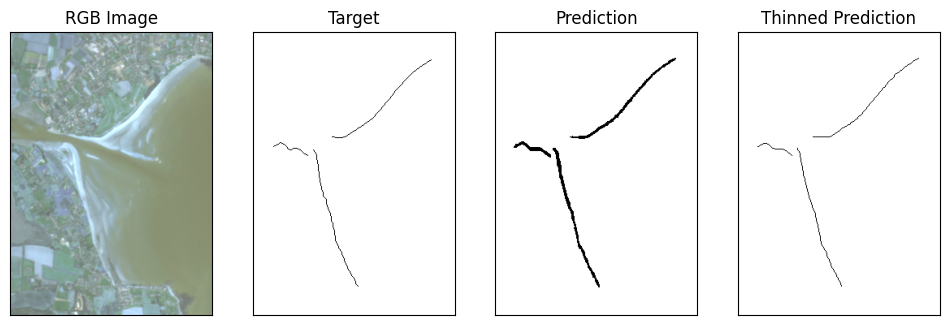

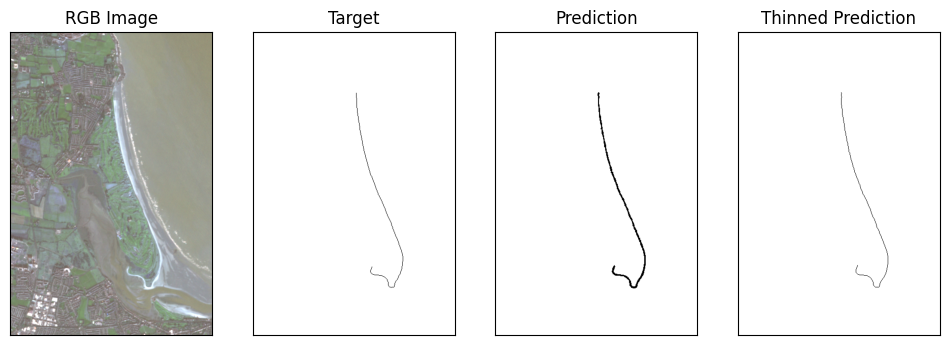

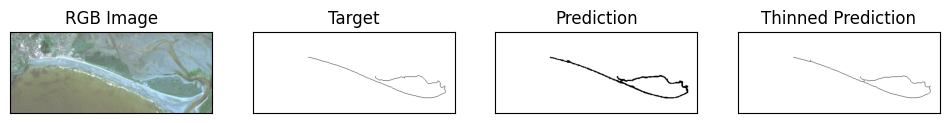

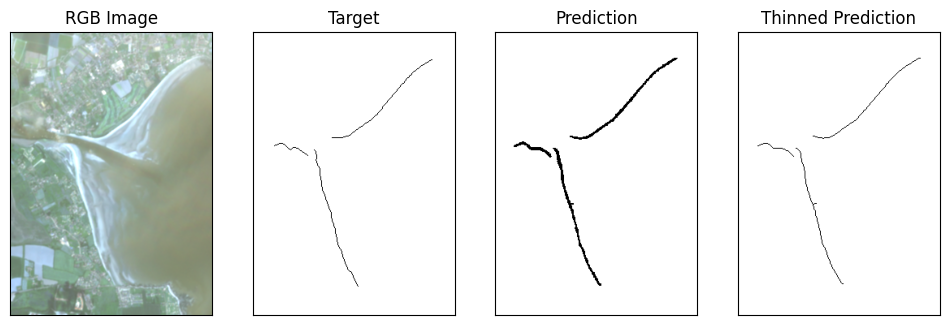

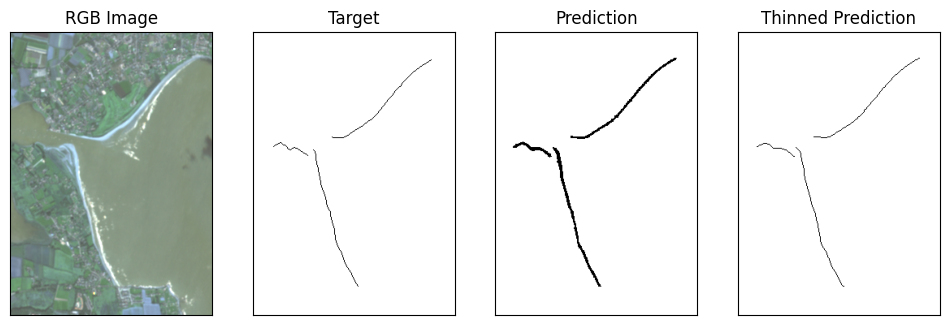

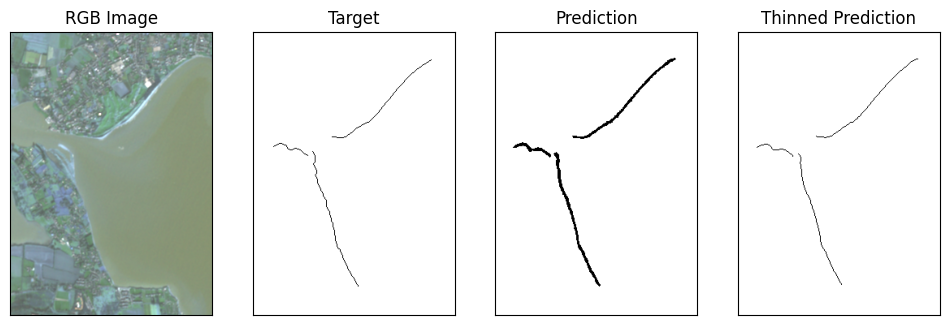

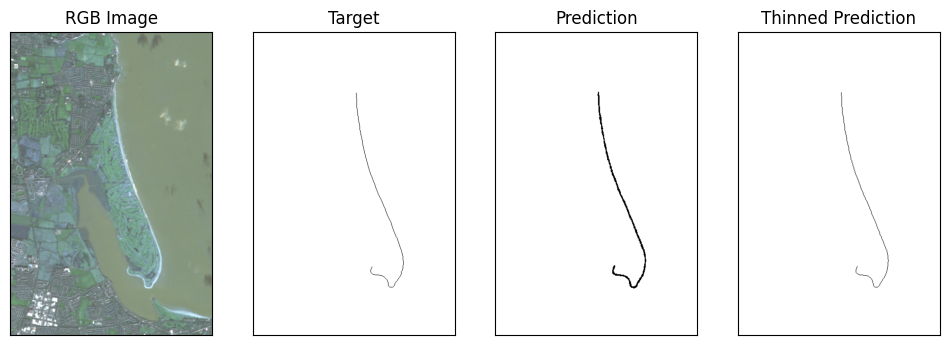

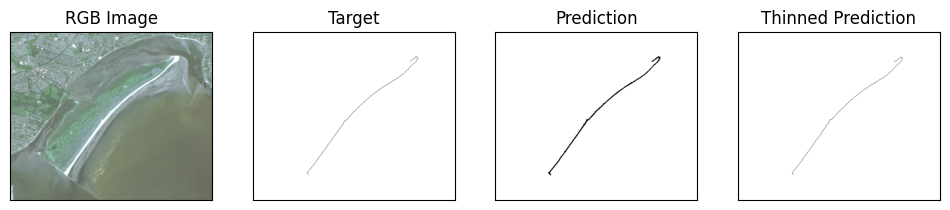

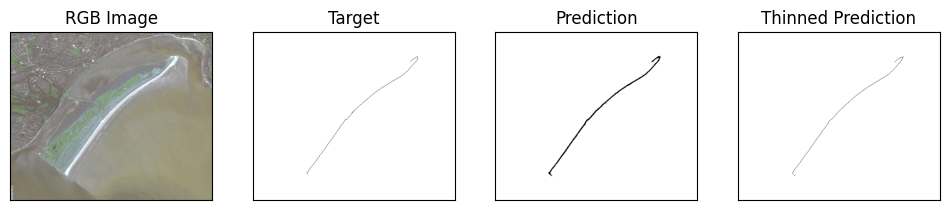

In [9]:
best_model_name = "SIVE_04JUN2025_HED_BigEarthNet_trainable_guided_wBCE.pth"


model_path = f'../models/SIVE_04JUN2025/{best_model_name}'
model, meta_data = utils.get_model(model_path)

print("Model metadata:")
for key, value in meta_data.items():
    print(f"{key}: {value}")

plot_all_predictions(model, meta_data, test_paths)

In [17]:
from skimage import measure

def get_longest_line(edge_map):
    """
    Post-process a 2D edge map to extract the longest continuous line.
    Args:
        pred (np.ndarray): 2D edge map.
        connect_distance (int): Maximum distance to connect points.
    Returns:
        np.ndarray: Processed edge map with the longest line.
    """
    
    labeled, num = measure.label(edge_map, connectivity=2, return_num=True)

    # Measure size of each component
    sizes = np.bincount(labeled.ravel())

    # Exclude background label (0)
    sizes[0] = 0

    # Find the label with the largest size
    largest_label = sizes.argmax()

    longest_line = (labeled == largest_label).astype(np.uint8)


    return longest_line

Number of connected components: 3


Text(0.5, 1.0, 'Longest Line')

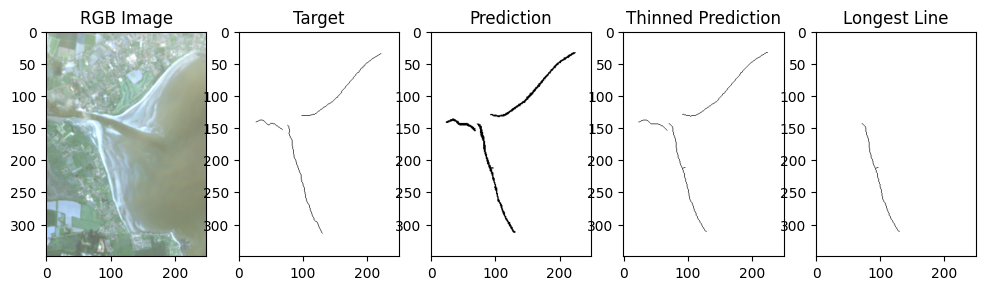

In [31]:
crop_remove = 200

path = test_paths[3]
image,  pred_full = eval.get_combined_pred(model,meta_data,points_dict, path, batch_size=1,post_process=False)
image = image[:,crop_remove:-crop_remove, crop_remove:-crop_remove]
pred_full = pred_full[crop_remove:-crop_remove, crop_remove:-crop_remove]

pred_thinned = utils.thin_edge_map(pred_full)

pred_longest = get_longest_line(pred_thinned)

from scipy.ndimage import label

labeled_array, num_features = label(pred_thinned, structure=np.ones((3, 3)))

print(f"Number of connected components: {num_features}")


fig, ax = plt.subplots(1, 5, figsize=(12, 6))
rgb_image = utils.get_rgb(image, contrast=0.3)
ax[0].imshow(rgb_image)
ax[0].set_title("RGB Image")    

ax[1].imshow(1-image[-1], cmap='gray')
ax[1].set_title("Target")

ax[2].imshow(1-pred_full, cmap='gray')
ax[2].set_title("Prediction")

ax[3].imshow(1-pred_thinned, cmap='gray')
ax[3].set_title("Thinned Prediction")

ax[4].imshow(1-pred_longest, cmap='gray')
ax[4].set_title("Longest Line")

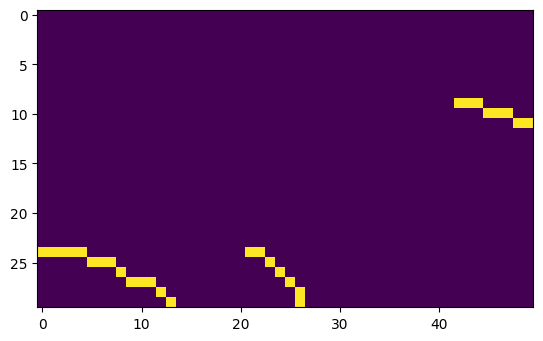

In [30]:
plt.imshow(pred_thinned[120:150,50:100])

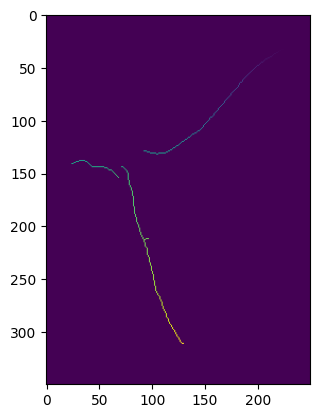

In [28]:
plt.imshow(labeled_array)

In [23]:
from scipy.ndimage import label
import numpy as np

# example binary image
mask = np.array([
    [0, 1, 1, 0],
    [0, 1, 0, 0],
    [1, 1, 0, 0],
])

labeled_array, num_features = label(mask)

print(f"Number of connected components: {num_features}")

Number of connected components: 1
